In [2]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statsmodels.stats.multitest import multipletests
# Imports for analysis

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'
jet_cmap = cm.get_cmap('Spectral')

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [4]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

def apply_specificity(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = np.atleast_1d(wideform_preds(row[col],all_chs))
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_spec'] = recall_score(row[col+'_bool']==False,ch_preds==False)
    return row

## Config

In [5]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Loading External Benchmark

In [6]:
alt_annots = pd.read_csv(ospj(metapath,'Results_Raw_FINAL.csv'))
alt_onset_annots_1k = alt_annots[(alt_annots['Cutoff Frequency'] == 1000) & (alt_annots['Symbol Number'] == str(1))]
grouped_annots = alt_onset_annots_1k.groupby(['Marker','Patient File']).apply(lambda x: [y['Channel Marked'] for _,y in x.iterrows()]).reset_index()
all_dice = []
for i_g, group in grouped_annots.groupby('Patient File'):
    if len(group) <= 1:
        continue
    dice_val = 0
    for i_annot in range(len(group)):
        for j_annot in range(i_annot+1,len(group)):
            dice_val += dice_score(np.atleast_1d(group.iloc[i_annot,2]),np.atleast_1d(group.iloc[j_annot,2]))
    dice_val /= (len(group)*(len(group)-1))/2
    all_dice.append(dice_val)
all_dice = np.atleast_1d(all_dice)

0.2788888888888889
0.15796024920598886


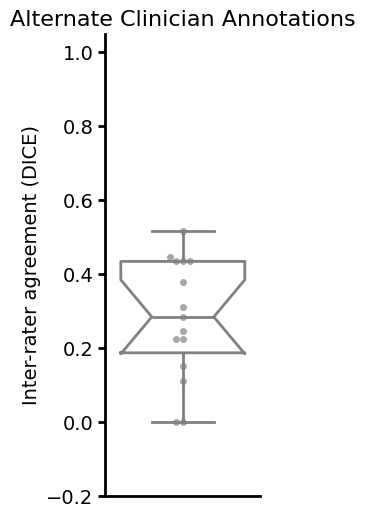

In [7]:
# all_dice = all_dice[all_dice > 0]
plt.figure(figsize=(2,6))
sns.boxplot(all_dice,color='gray',fill=False,notch=True)
sns.swarmplot(all_dice,color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
print(np.mean(all_dice))
print(np.std(all_dice))
sns.despine()
plt.title('Alternate Clinician Annotations');
plt.ylabel('Inter-rater agreement (DICE)');
plt.ylim([-.2,1.05]);
plt.xticks([]);

In [8]:
external_annots = pd.DataFrame(np.hstack((all_dice.reshape(-1,1),np.array(["Ext. Clin."]*len(all_dice)).reshape(-1,1))),columns=["dice","model"])

## Formatting Model Predictions

### Channel level

In [9]:
# # Loading in human annotations with consensus annotation already created
# annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
# annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# # Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"pretrain_predicted_channels_norsc.pkl"))
# predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# # Sorting
# predicted_channels.sort_values('approximate_onset',inplace=True)
# # predicted_channels = predicted_channels[predicted_channels.stim == 0]
# annotations_df.sort_values('approximate_onset',inplace=True)

# # Creating a merged table with human and machine annotations based on approximate seizure onset time
# pred_channels_wannots = pd.merge_asof(predicted_channels,
#                                     annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
#                                     on='approximate_onset',by='Patient',
#                                     tolerance = 240,
#                                     direction='nearest')
# pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
# pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
# pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# # pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)
# # # pred_channels_wspec = pred_channels_wannots.apply(apply_specificity,axis=1)

In [10]:
# # pred_channels_wspec.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wspec.pkl"))
# pred_channels_wdice.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_norsc.pkl"))
# # pred_channels_wkappa.to_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wkappa_nor.pkl"))

## Channel Agreement Optimization

### Calculating clinician consensus


In [11]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'threshold_tuning_consensus.pkl'))

In [12]:
# consensus_annots = consensus_annots[consensus_annots.stim == 0]
consensus_annots = consensus_annots[consensus_annots.clinician.apply(lambda x: len(x)>2)]
spread_consensus_annots = consensus_annots.copy()
note_type = 'ueo'
for i_r, row in consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]

note_type = 'sec'
for i_r, row in spread_consensus_annots.iterrows():
    scores = 0
    annots = row[note_type]
    for i_annot in range(len(annots)):
        for j_annot in range(i_annot+1,len(annots)):
            scores += f1_score(annots[i_annot],annots[j_annot])
    spread_consensus_annots.loc[i_r,'f1'] = scores/(len(annots)*(len(annots)-1)/2)
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]

In [18]:
x = consensus_annots[consensus_annots.patient == 'HUP238']
x['ueo_chs'] = x.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
x

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,f1,model,dice,ueo_chs
40,HUP238_1,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[10653.02, 10653.16, 10652.98, 10653.04, 10653...","[[False, True, False, False, False, False, Fal...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,10640.8600,10792.34,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",10653.04,"[False, True, False, False, False, False, Fals...","[False, True, False, False, False, False, Fals...",0.841977,Clin.,0.841977,"[LB01, LB02, LC01, LC02, LC03]"
41,HUP238_2,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[290008.46, 290008.61, 290009.78, 290008.61, 2...","[[False, True, True, False, False, False, Fals...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,290006.9060,290152.56,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",290008.61,"[False, True, True, False, False, False, False...","[False, True, True, True, False, False, False,...",0.720979,Clin.,0.720979,"[LB01, LB02, LC01, LC02]"
42,HUP238_3,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[412269.46, 412269.46, 412269.46, 412269.29, 4...","[[False, False, False, False, False, False, Fa...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,412267.6988,412383.25,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",412269.46,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.800000,Clin.,0.800000,"[LC01, LC02]"
43,HUP238_4,"[CK, DZ, EC, JJ, JK]",HUP238,"[[False, False, False, False, False, False, Fa...","[465566.01, 465565.78, 465566.05, 465566.04, 4...","[[False, True, False, False, False, False, Fal...","[Fp02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP238_phaseII,465564.6090,465680.72,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",465566.04,"[False, True, True, False, False, False, False...","[False, True, True, True, True, True, True, Tr...",0.866667,Clin.,0.866667,"[LC01, LC02]"


In [ ]:
np.array(consensus_annots.loc[10,'all_chs'])[consensus_annots['ueo_any']]

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,f1,model,dice
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.5300,68944.57,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.768519,Clin.,0.768519
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.2600,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.251852,Clin.,0.251852
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.7900,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.000000,Clin.,0.000000
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.7200,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23000,"[False, False, False, True, True, False, False...","[False, False, True, True, True, True, False, ...",0.600000,Clin.,0.600000
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.2500,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58000,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.287879,Clin.,0.287879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,HUP263_3,"[EC, JJ, JK]",HUP263,"[[False, False, False, False, False, False, Fa...","[272461.42, 272461.47, 272461.47]","[[False, True, True, True, False, False, False...","[FP02, LA01, LA02, LA03, LA04, LA05, LA06, LA0...",HUP263_phaseII,272461.8305,272529.97,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",272461.47000,"[False, True, True, True, True, False, False, ...","[False, True, True, True, True, True, False, F...",0.948718,Clin.,0.948718
71,HUP266_1,"[CK, DZ, JJ]",HUP266,"[[False, False, False, False, False, False, Fa...","[12510.19, 12510.16171, 12510.14]","[[False, False, False, False, False, False, Fa...","[R1PO01, R1PO02, R1PO03, R1PO04, R1PO05, R1PO0...",HUP266_phaseII,12508.6700,12553.34,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",12510.16171,"[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",0.655556,Clin.,0.655556
72,HUP266_2,"[CK, DZ, JJ]",HUP266,"[[False, False, False, False, False, False, Fa...","[253213.13, 253213.1972, 253212.68]","[[False, False, False, False, False, False, Fa...","[R1PO01, R1PO02, R1PO03, R1PO04, 

0.6181256126195522


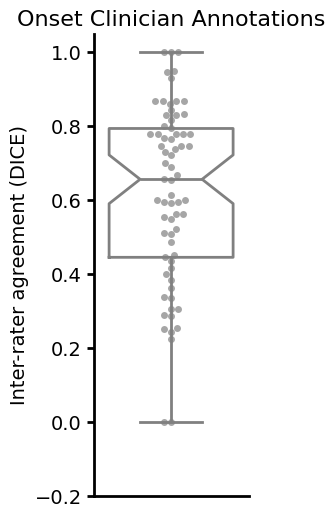

In [55]:
plt.figure(figsize=(2,6))
sns.boxplot(consensus_annots["dice"],color='gray',fill=False,notch=True)
sns.swarmplot(consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Onset Clinician Annotations');
plt.ylabel('Inter-rater agreement (DICE)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
print(consensus_annots.dice.mean())

0.6221326670352404


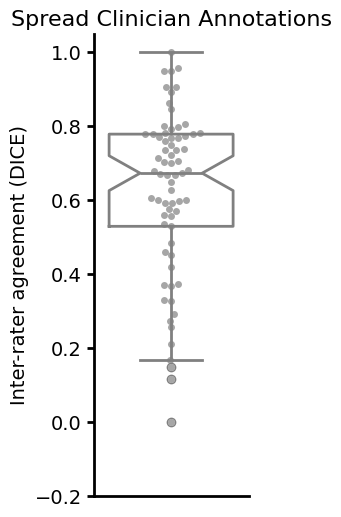

In [58]:
plt.figure(figsize=(2,6))
sns.boxplot(spread_consensus_annots["dice"],color='gray',fill=False,notch=True)
sns.swarmplot(spread_consensus_annots["dice"],color='gray',alpha=0.7)
# sns.pointplot(all_dice,color='gray',marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title('Spread Clinician Annotations');
plt.ylabel('Inter-rater agreement (DICE)');
plt.ylim([-.2,1.05]);
plt.xticks([]);
print(spread_consensus_annots.dice.mean())

In [22]:
sc.stats.mannwhitneyu(consensus_annots["dice"],spread_consensus_annots["dice"])

MannwhitneyuResult(statistic=2387.0, pvalue=0.979614618426737)

### Comparing annotators

In [23]:
sc.stats.mannwhitneyu(consensus_annots.dice,all_dice)

MannwhitneyuResult(statistic=902.5, pvalue=7.061182311555691e-06)

### Data Prep

In [20]:
anntype='consensus'
mdl_anntype = 'loose'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice_norsc.pkl"))
mdl_preds = mdl_preds[mdl_preds.model != 'NRG']

In [21]:
# mdl_preds = mdl_preds[mdl_preds.stim == 0]

In [22]:
print(len(mdl_preds[mdl_preds.stim==1].approximate_onset.unique()))
print(len(mdl_preds.approximate_onset.unique()))
print(len(mdl_preds.Patient.unique()))
print(len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].Patient.unique()))
print(len(mdl_preds[mdl_preds.Patient.apply(lambda x: 'HUP' in x)].approximate_onset.unique()))

34
78
28
19
63


In [23]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [24]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
# melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_spec',f'sec_chs_{mdl_anntype}_{anntype}_spec']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.Patient.unique()

array(['CHOP005', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037',
       'CHOP041', 'CHOP045', 'CHOP049', 'HUP224', 'HUP225', 'HUP229',
       'HUP230', 'HUP235', 'HUP238', 'HUP246', 'HUP247', 'HUP249',
       'HUP250', 'HUP253', 'HUP257', 'HUP261', 'HUP263', 'HUP266',
       'HUP267', 'HUP273', 'HUP275', 'HUP288'], dtype=object)

In [25]:
tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_consensus_loose_dice']
val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_consensus_loose_dice']
# tune_preds_long = mdl_preds_long[mdl_preds_long.annot == 'ueo_chs_loose_consensus_spec']
# val_preds_long = mdl_preds_long[mdl_preds_long.annot == 'sec_chs_loose_consensus_spec']

### Threshold sweeping

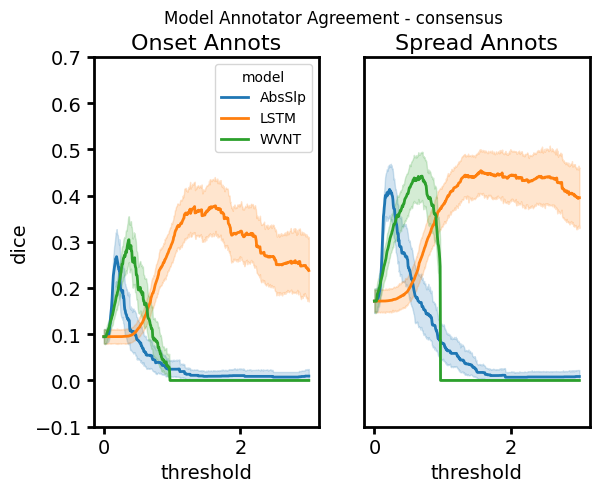

In [27]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((-.1,.7))
axs[0].set_title('Onset Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1],legend=False)
axs[1].set_ylim((-.1,.7))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('Spread Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')
fig.savefig(ospj(figpath,f'ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

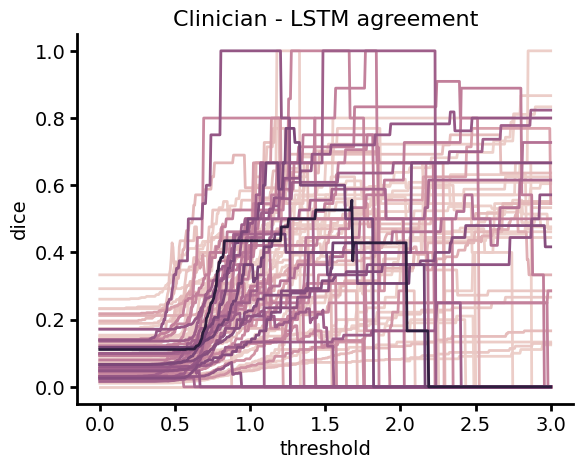

In [30]:
fig,ax = plt.subplots()
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')],hue_order='Patient',x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=False)
# plt.xlim([0,1])
plt.title('Clinician - LSTM agreement')
sns.despine()
fig.savefig(ospj(figpath,f'pt_LSTM_ueo_ch_dice_{anntype}-{mdl_anntype}.pdf'),transparent=True)

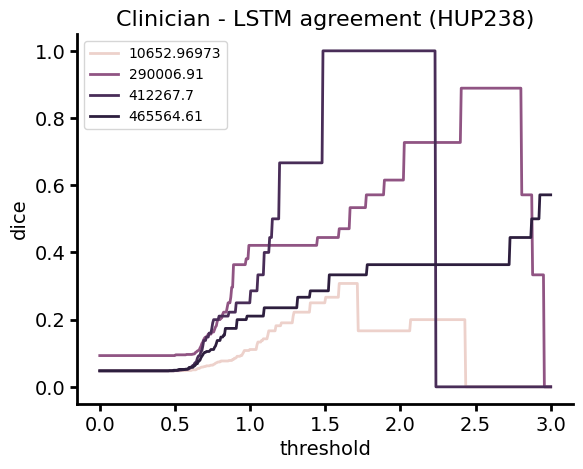

In [27]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')& (mdl_preds_long.Patient == 'HUP238')],x='threshold',y='dice',hue='approximate_onset',errorbar=None,legend=True)
# plt.xlim([0,1])
plt.title('Clinician - LSTM agreement (HUP238)')
sns.despine()
plt.legend()

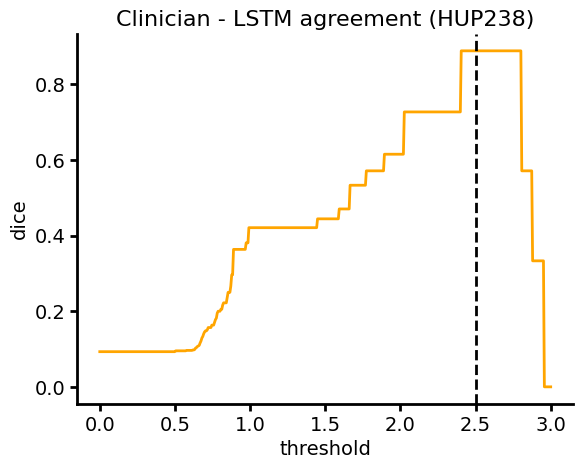

In [35]:
ax = sns.lineplot(data=mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM')& (mdl_preds_long.Patient == 'HUP238')& (mdl_preds_long.approximate_onset == 290006.91)],x='threshold',y='dice',color='orange',errorbar=None,legend=False)
# plt.xlim([0,1])
plt.axvline(2.5,c='black',linestyle='--')
plt.title('Clinician - LSTM agreement (HUP238)')
sns.despine()

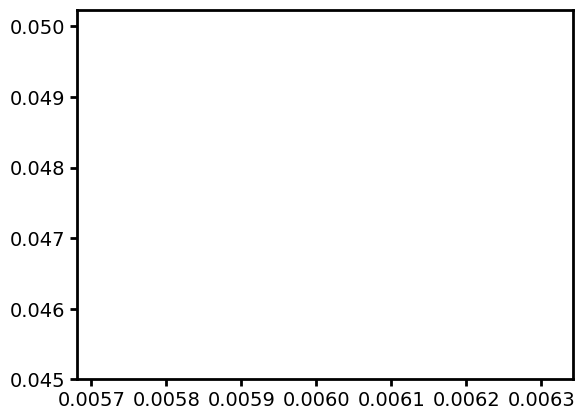

In [27]:
single_plot_data = mdl_preds_long[(mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice') & (mdl_preds_long.model == 'LSTM') & (mdl_preds_long.Patient == 'HUP238')].iloc[1,:]
plt.plot(single_plot_data.threshold,single_plot_data.dice)

### Tuning at the seizure level

#### Tuning and testing on onset

In [50]:
optimal_threshold_preds = tune_preds_long.loc[tune_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold','ueo_chs_loose','ueo_consensus_chs']]

In [51]:
optimal_threshold_preds

,model,dice,Patient,stim,approximate_onset,threshold,ueo_chs_loose,ueo_consensus_chs
99,AbsSlp,0.235294,CHOP005,1.0,68881.53,0.198397,"[LI04, LI05, LI06, LI07, LI08, LI09, LI10, LK0...","[LK01, LK02, LK03, LK04]"
1411,LSTM,0.166667,CHOP005,1.0,68881.53,2.825651,"[LF08, LF09, LH01, LH02, LI04, LI05, LI06, LI0...","[LK01, LK02, LK03, LK04]"
314,WVNT,0.181818,CHOP005,1.0,68881.53,0.625251,"[LA01, LA02, LA03, LF07, LF08, LF09, LI04, LI0...","[LK01, LK02, LK03, LK04]"
1644,AbsSlp,0.444444,CHOP024,1.0,87579.25,0.288577,"[LF01, LF02, LF05, LF06]","[LE10, LF02, LF03, LF04, LF05]"
2839,LSTM,0.545455,CHOP024,1.0,87579.25,2.681363,"[LE09, LE10, LF01, LF02, LF05, LF06]","[LE10, LF02, LF03, LF04, LF05]"
...,...,...,...,...,...,...,...,...
114754,LSTM,0.285714,HUP288,1.0,73007.74,1.509018,"[RA01, RA02, RB01, RB02, RB03, RC01, RC02, RI0...","[RA01, RA02]"
114305,WVNT,0.333333,HUP288,1.0,73007.74,0.607214,"[RA01, RA02, RB01, RB02, RC01, RC02, RE02, RE0...","[RA01, RA02]"
115566,AbsSlp,0.064516,HUP288,0.0,251098.53,0.132265,"[RA02, RA03, RA04, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02]"
116188,LSTM,0.307692,HUP288,0.0,251098.53,1.376754,"[RA01, RA02, RA03, RB01, RB02, RB03, RC01, RC0...","[RA01, RA02]"


In [59]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
all_plot_agreements = pd.concat([optimal_threshold_preds,consensus_annots[["model","dice","stim"]]])

In [60]:
for mdl in optimal_threshold_preds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_threshold_preds[optimal_threshold_preds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=3768.5, pvalue=2.9010675310043337e-05)
LSTM
MannwhitneyuResult(statistic=3061.0, pvalue=0.15141584215584808)
WVNT
MannwhitneyuResult(statistic=3644.0, pvalue=0.00021742713087214658)


In [61]:
# all_plot_agreements = pd.concat([all_plot_agreements,external_annots])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

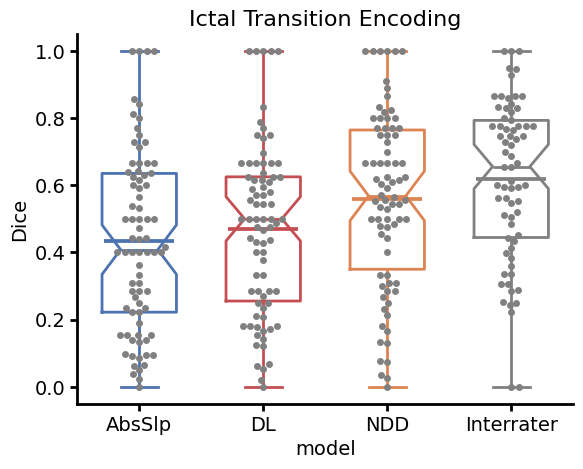

In [62]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([colors,[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None)
sns.despine()
plt.ylabel('Dice')
plt.title("Ictal Transition Encoding")
plt.savefig(ospj(figpath,'onset_tuned_onset_detection.pdf'))

In [63]:
all_plot_agreements = pd.concat([all_plot_agreements,external_annots])


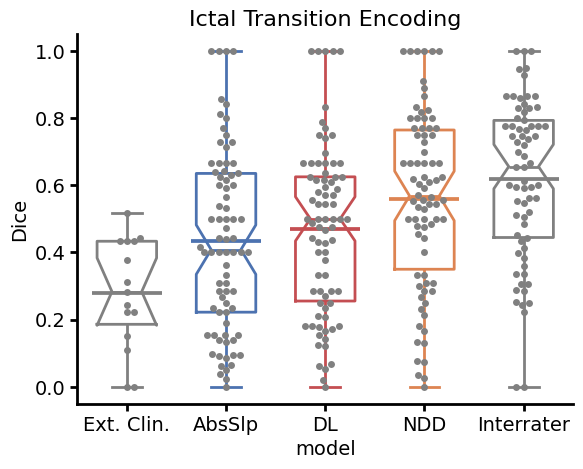

In [72]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([[.5,.5,.5],colors,[.5,.5,.5]]),
                 order=['Ext. Clin.','AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray',order=['Ext. Clin.','AbsSlp','DL','NDD','Interrater'])
g = sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([[.5,.5,.5],np.array(colors),[.5,.5,.5]]),
              order = ['Ext. Clin.','AbsSlp','DL','NDD','Interrater'],marker='_',markersize=50,errorbar=None)
sns.despine()
plt.ylabel('Dice')
plt.title("Ictal Transition Encoding")
g.invert_yaxis()

In [28]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        print(np.mean(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice']), np.mean(all_plot_agreements[all_plot_agreements.model == j_mdl]['dice']))
        stat,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(stat,p)
multipletests(all_ps[:2])

AbsSlp NDD
0.38903198668265754 0.5788670844234555
596.0 0.0019158351967788626
NDD DL
0.5788670844234555 0.532149776943321
1077.5 0.3621700116742693
NDD Interrater
0.5788670844234555 0.6445102304255622
732.5 0.33792365071914476


(array([ True, False]),
 array([0.003828  , 0.36217001]),
 0.025320565519103666,
 0.025)

In [29]:
sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == 'NDD']['dice'],all_dice)

MannwhitneyuResult(statistic=550.0, pvalue=0.00013153038688396444)

#### Testing on spread

In [30]:
val_tuned_thresholds = val_preds_long[['Patient','approximate_onset','model','threshold','dice']].merge(optimal_threshold_preds[['Patient','approximate_onset','model','threshold']],on=['Patient','approximate_onset','model','threshold'],how='inner')

In [31]:
val_tuned_thresholds = val_preds_long.loc[val_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset",'threshold','ueo_chs_loose','ueo_consensus_chs']]

In [32]:
spread_consensus_annots["model"] = ["Clin."]*len(spread_consensus_annots)
spread_consensus_annots["dice"] = spread_consensus_annots["f1"]
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])

In [33]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

In [34]:
all_plot_agreements[all_plot_agreements.model == 'Interrater'].dice.mean()

0.6657173865704795

In [35]:
all_ps = []
for mdl in all_plot_agreements.model.unique():
    print(mdl)
    p = sc.stats.mannwhitneyu(spread_consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice)
    print(p)
    all_ps.append(p[1])
multipletests(all_ps)

AbsSlp
MannwhitneyuResult(statistic=940.0, pvalue=0.33578640909832214)
NDD
MannwhitneyuResult(statistic=740.0, pvalue=0.37442352575633486)
DL
MannwhitneyuResult(statistic=845.5, pvalue=0.9332934885817148)
Interrater
MannwhitneyuResult(statistic=722.0, pvalue=1.0)


(array([False, False, False, False]),
 array([0.80536048, 0.80536048, 0.99555024, 1.        ]),
 0.012741455098566168,
 0.0125)

Text(0.5, 1.0, 'Ictal Activity Encoding')

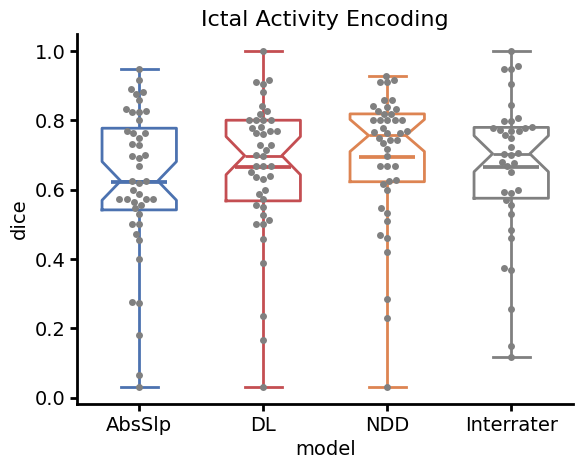

In [36]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'])
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=40,errorbar=None)
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False,whis=100)
sns.despine()
plt.title("Ictal Activity Encoding")

In [37]:
all_ps = []
for i_mdl in optimal_threshold_preds.model.unique():
    for j_mdl in optimal_threshold_preds.model.unique():
        print(i_mdl,j_mdl)
        print(np.mean(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice']), np.mean(val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice']))

        p = sc.stats.mannwhitneyu(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        d=cohens_d(val_tuned_thresholds[val_tuned_thresholds.model == i_mdl]['dice'],
                 val_tuned_thresholds[val_tuned_thresholds.model == j_mdl]['dice'])
        print(d)
        all_ps.append(p)
        print(p)

AbsSlp AbsSlp
0.6232083043664715 0.6232083043664715
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
AbsSlp LSTM
0.6232083043664715 0.6937703931902212
-0.3454014654635872
MannwhitneyuResult(statistic=759.5, pvalue=0.08247829374316334)
AbsSlp WVNT
0.6232083043664715 0.6640867803574279
-0.19720393340841363
MannwhitneyuResult(statistic=860.0, pvalue=0.36947894268493897)
LSTM AbsSlp
0.6937703931902212 0.6232083043664715
0.3454014654635872
MannwhitneyuResult(statistic=1176.5, pvalue=0.08247829374316334)
LSTM LSTM
0.6937703931902212 0.6937703931902212
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
LSTM WVNT
0.6937703931902212 0.6640867803574279
0.1530683487492461
MannwhitneyuResult(statistic=1092.0, pvalue=0.3023208388067322)
WVNT AbsSlp
0.6640867803574279 0.6232083043664715
0.19720393340841363
MannwhitneyuResult(statistic=1076.0, pvalue=0.36947894268493897)
WVNT LSTM
0.6640867803574279 0.6937703931902212
-0.1530683487492461
MannwhitneyuResult(statistic=844.0, pvalue=0.30232083880673

### Tuning at the patient level

In [1]:
# Group by 'Patient', 'model', and 'threshold' to calculate the average dice score for each threshold
avg_dice_per_threshold = tune_preds_long.groupby(['Patient', 'model', 'threshold','annot'])['dice'].mean().reset_index()

# Now, for each 'Patient' and 'model', find the threshold that maximizes the average dice score
threshold_list = avg_dice_per_threshold.loc[avg_dice_per_threshold.groupby(['Patient', 'model','annot'])['dice'].idxmax()]

# The result will contain the patient, model, threshold, and the average dice score
threshold_list = threshold_list[['Patient', 'model', 'threshold', 'dice']].reset_index(drop=True)

NameError: name 'tune_preds_long' is not defined

In [39]:
# threshold_list.to_pickle(ospj(prodatapath,'patient_tuned_classification_thresholds.pkl'))

In [40]:
threshold_list

,Patient,model,threshold,dice
0,CHOP041,AbsSlp,0.210421,0.222222
1,CHOP041,LSTM,1.376754,0.232558
2,CHOP041,WVNT,0.462926,0.432432
3,CHOP049,AbsSlp,0.228457,0.439024
4,CHOP049,LSTM,2.777555,0.536585
...,...,...,...,...
58,HUP275,LSTM,1.004008,0.300000
59,HUP275,WVNT,0.348697,0.428571
60,HUP288,AbsSlp,0.132265,0.064516
61,HUP288,LSTM,1.376754,0.307692


In [41]:
tuned_thresholds = tune_preds_long[tune_preds_long.set_index(['Patient', 'model', 'threshold']).index.isin(threshold_list.set_index(['Patient', 'model', 'threshold']).index)]
val_tuned_thresholds = val_preds_long[val_preds_long.set_index(['Patient', 'model', 'threshold']).index.isin(threshold_list.set_index(['Patient', 'model', 'threshold']).index)]

#### Onset

In [112]:
all_plot_agreements = pd.concat([tuned_thresholds,consensus_annots[["model","dice"]]])

NameError: name 'tuned_thresholds' is not defined

In [43]:
for mdl in tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice))
    print(cohens_d(consensus_annots.f1,all_plot_agreements[all_plot_agreements.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=1358.0, pvalue=1.2056294306835664e-06)
1.280516834088006
WVNT
MannwhitneyuResult(statistic=1188.5, pvalue=0.0010558502491396426)
0.7665068643146271
LSTM
MannwhitneyuResult(statistic=1069.0, pvalue=0.03050551804359798)
0.5122203696369404


In [111]:
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']
all_plot_agreements.loc[all_plot_agreements.model == 'LSTM',['model']] = 'NDD'
all_plot_agreements.loc[all_plot_agreements.model == 'WVNT',['model']] = 'DL'
all_plot_agreements.loc[all_plot_agreements.model == 'Clin.',['model']] = 'Interrater'

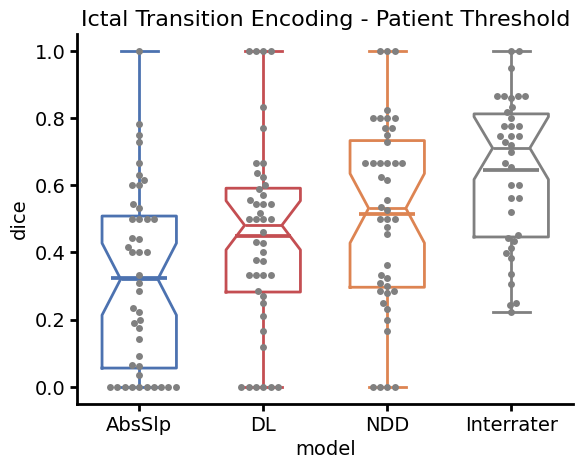

In [45]:
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[0,3,1]]
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray', order = ['AbsSlp','DL','NDD','Interrater'])
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','DL','NDD','Interrater'],marker='_',markersize=40,errorbar=None)
sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','DL','NDD','Interrater'],width=.6,notch=True,fill=False)
sns.despine()
plt.title("Ictal Transition Encoding - Patient Threshold")
plt.savefig(ospj(figpath,'patient_tuned_onset_detection.pdf'))

In [46]:
all_ps = []
mdl_strs = all_plot_agreements.model.unique()
for idx_mdl in range(len(mdl_strs)):
    for jdx_mdl in range(idx_mdl+1,len(mdl_strs)):
        i_mdl = mdl_strs[idx_mdl]
        j_mdl = mdl_strs[jdx_mdl]
        if (i_mdl != 'NDD') & (j_mdl != 'NDD'):
            continue
        print(i_mdl,j_mdl)
        _,p = sc.stats.ttest_ind(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        d=cohens_d(all_plot_agreements[all_plot_agreements.model == i_mdl]['dice'],
                 all_plot_agreements[all_plot_agreements.model == j_mdl]['dice'])
        all_ps.append(p)
        print(p)
_,p = sc.stats.mannwhitneyu(all_plot_agreements[all_plot_agreements.model == 'NDD'].dice,consensus_annots.f1)
print(p)
multipletests(all_ps[:2])

AbsSlp NDD
0.0016345881775544475
DL NDD
0.2727044128987437
NDD Interrater
0.023294461061032733
0.03050551804359798


(array([ True, False]),
 array([0.0032665 , 0.27270441]),
 0.025320565519103666,
 0.025)

#### Stim vs. Spont

In [109]:
print(cohens_d(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice))
sc.stats.mannwhitneyu(all_plot_agreements[(all_plot_agreements.stim == 0) & (all_plot_agreements.model == 'NDD')].dice,
all_plot_agreements[(all_plot_agreements.stim == 1) & (all_plot_agreements.model == 'NDD')].dice)

0.18252854076768238


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

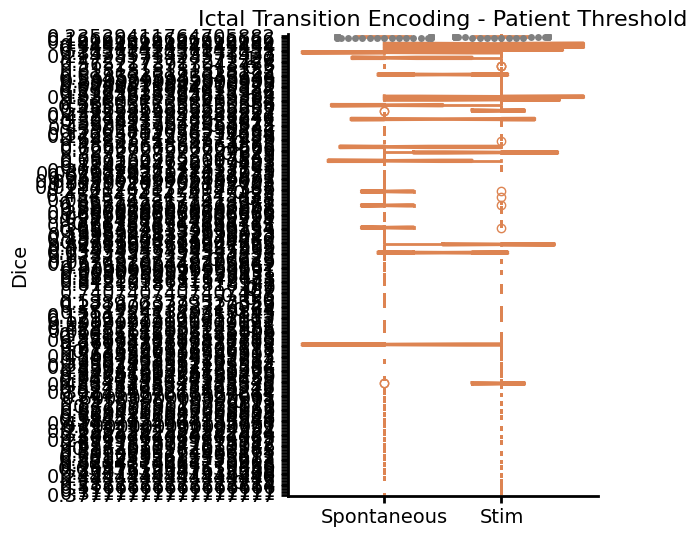

In [110]:
plt.figure(figsize=(4,6))
colors = np.array(sns.color_palette("deep", 4))
colors = colors[[1,1]]
stim_plot_agreements = all_plot_agreements[all_plot_agreements.model == 'NDD']
sns.swarmplot(stim_plot_agreements,x='stim',y='dice',color='gray',native_scale=True)
sns.pointplot(stim_plot_agreements,x='stim',y='dice',palette=colors,
            marker='_',markersize=40,errorbar=None,native_scale=True)
sns.boxplot(all_plot_agreements,x='stim',y='dice',palette=colors,width=.6,notch=True,fill=False,native_scale=True)
sns.despine()
plt.xticks([0,1],['Spontaneous','Stim'])
plt.title("Ictal Transition Encoding - Patient Threshold")
plt.xlabel('')
plt.ylabel('Dice')
plt.savefig(ospj(figpath,'stim_vs_spont_detection.pdf'))

#### Spread

In [ ]:
all_plot_agreements = pd.concat([val_tuned_thresholds,spread_consensus_annots[["model","dice"]]])
all_plot_agreements = all_plot_agreements[all_plot_agreements.model != 'NRG']

In [ ]:
for mdl in val_tuned_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(spread_consensus_annots.f1,val_tuned_thresholds[val_tuned_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=4077.5, pvalue=7.425460234723153e-08)
WVNT
MannwhitneyuResult(statistic=4172.0, pvalue=9.094099170810828e-09)
LSTM
MannwhitneyuResult(statistic=3703.0, pvalue=8.618592564468472e-05)


Text(0.5, 1.0, 'Patient-level Optimal Onset Thresholds Detecting Spread')

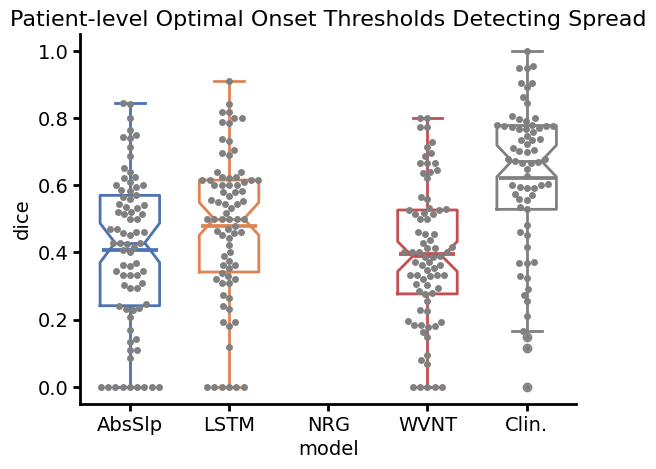

In [ ]:
colors = sns.color_palette("deep", 4)
bx = sns.boxplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
                 order=['AbsSlp','LSTM','NRG','WVNT','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(all_plot_agreements,x='model',y='dice',color='gray')
sns.pointplot(all_plot_agreements,x='model',y='dice',palette=np.vstack([np.array(colors),[.5,.5,.5]]),
              order = ['AbsSlp','LSTM','NRG','WVNT','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.title("Patient-level Optimal Onset Thresholds Detecting Spread")

## KDE Model Predictions

In [102]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
# predicted_channels = pd.read_pickle(ospj(prodatapath,"gamma_predicted_channels_opt.pkl"))
predicted_channels = pd.read_pickle(ospj(prodatapath,"kdeknee_predicted_channels_nor.pkl"))
# predicted_channels = 
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[(predicted_channels.stim == 0)]# & predicted_channels.Patient.apply(lambda x: 'HUP' in x)]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
# pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [103]:
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_consensus_loose_dice > 0]
# pred_channels_wdice = pred_channels_wdice[pred_channels_wdice.ueo_chs_strict.apply(lambda x: len(x) > 0)]

In [104]:
pred_channels_wdice

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_loose_dice,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice
136,CHOP041,CHOP041,NRG,0.0,416768.18,416768.18,0.260107,"[LE07, LI04, LI03, LE06, LB02, LK04, LB01, LN0...","[LA01, LA02, LA04, LA05, LB01, LB02, LB03, LC0...",[LH10],...,0.120000,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.111111,0.120000,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.027027,0.053333,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.027027,0.053333
137,CHOP041,CHOP041,AbsSlp,0.0,416768.18,416768.18,0.167699,"[LJ01, LS05, LS04, LS01, LR08, LR04, LR03, LP0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...","[LG09, LH09, LF06, LF04, LG08]",...,0.150943,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.148148,0.150943,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.102564,0.170732,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.102564,0.170732
138,CHOP041,CHOP041,WVNT,0.0,416768.18,416768.18,0.295461,"[LA05, LP08, LI02, LI03, LI04, LI05, LF01, LF0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA1...","[LP02, LA10]",...,0.232558,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.250000,0.232558,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.000000,0.000000,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.000000,0.000000
139,CHOP041,CHOP041,LSTM,0.0,416768.18,416768.18,1.103037,"[LJ01, LF02, LD03, LC05, LL02, LL01, LR04, LR0...","[LA01, LA02, LA04, LA05, LA06, LA07, LA08, LA0...",[],...,0.208333,"[LF02, LF03, LI02, LI03, LI04, LI05, LI06, LI0...",0.219178,0.208333,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.000000,0.000000,"[LA01, LA02, LA04, LA05, LA06, LF01, LF02, LF0...",0.000000,0.000000
24,CHOP049,CHOP049,LSTM,0.0,114973.49,114973.49,0.940670,"[LF01, LC04, LC03, LC02, LC01, LB09, LB07, LB0...","[LA02, LA03, LA04, LA05, LA06, LA07, LA08, LA0...",[],...,0.243590,"[LC01, LC02, LC03, LD07, LE10, LE09, LF01, LF0...",0.237037,0.243590,"[LC01, LC02, LC03, LC04, LC05, LC06, LD07, LF0...",0.000000,0.000000,"[LC01, LC02, LC03, LC04, LC05, LC06, LD07, LF0...",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,HUP275,HUP275_phaseII,NRG,0.0,297659.44,297659.44,0.883253,[LC09],"[LC09, LC10]",[],...,0.000000,"[LA09, LA10, LA11]",0.000000,0.000000,"[LA09, LA10, LA11, LB09, LB10, LB11, LC09, LC1...",0.000000,0.000000,"[LA09, LA10, LA11, LB09, LB10, LB11, LC09, LC1...",0.000000,0.000000
56,HUP288,HUP288_phaseII,LSTM,0.0,251098.53,251098.53,1.442908,"[RA01, RE02, RE01, RC02, RB02, RB01, RC01, RA0...","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RC0...",[],...,0.266667,"[RA01, RA02]",0.363636,0.266667,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000
57,HUP288,HUP288_phaseII,AbsSlp,0.0,251098.53,251098.53,0.177443,"[RC01, RB01]","[RB01, RB02, RC01, RC02]",[],...,0.000000,"[RA01, RA02]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000
58,HUP288,HUP288_phaseII,WVNT,0.0,251098.53,251098.53,0.280660,"[RA01, RF01, RP05, RP06, RE03, RE01, RX01, RX0...","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RB0...","[RP02, RZ02]",...,0.108108,"[RA01, RA02]",0.153846,0.108108,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000,"[RA01, RA02, RB01, RB02, RC01]",0.000000,0.000000


In [105]:
print(len(pred_channels_wdice.Patient.unique()),len(pred_channels_wdice.approximate_onset.unique()))

21 44


In [106]:
pred_type = 'ueo_any_loose_dice'
pred_channels_wdice['dice'] = pred_channels_wdice[pred_type]

In [107]:
pred_channels_wdice = pd.concat([pred_channels_wdice,consensus_annots[consensus_annots.stim == 0],external_annots]).reset_index(drop=True)

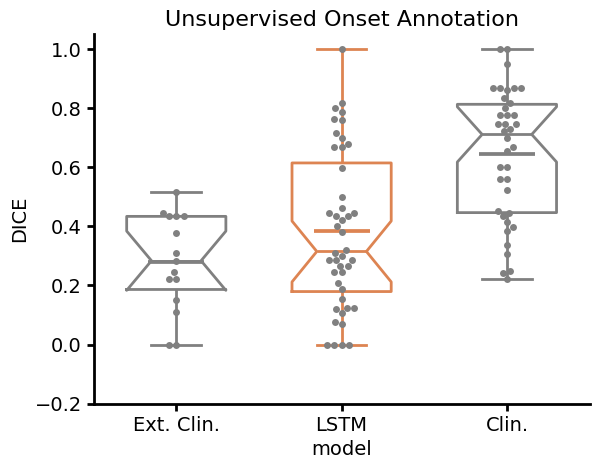

In [108]:
colors = np.array(sns.color_palette("deep", 4))[1]
kde_colors = np.vstack([[.5,.5,.5],np.array(colors),[.5,.5,.5]])
sns.boxplot(pred_channels_wdice,x='model',y="dice",palette=kde_colors,order=['Ext. Clin.','LSTM','Clin.'],width=.6,notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y="dice",color='gray',order=['Ext. Clin.','LSTM','Clin.'])
sns.pointplot(pred_channels_wdice,x='model',y="dice",palette=kde_colors,order = ['Ext. Clin.','LSTM','Clin.'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylabel('DICE')
plt.ylim([-.2,1.05])
plt.title("Unsupervised Onset Annotation")
bx.invert_yaxis()

Text(0.5, 1.0, 'KDE Unsupervised Annotation')

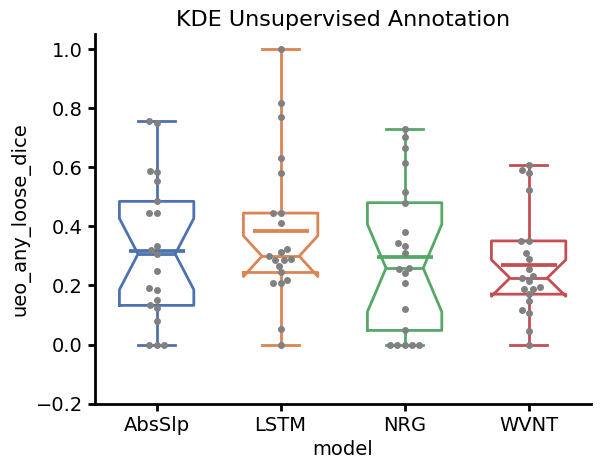

In [ ]:
pt_pred_channels_wdice = pred_channels_wdice.groupby(['Patient','model'])[[pred_type]].mean().reset_index()
bx = sns.boxplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],width=.6,notch=True,fill=False,whis=100)
sns.swarmplot(pt_pred_channels_wdice,x='model',y=pred_type,color='gray')
sns.pointplot(pt_pred_channels_wdice,x='model',y=pred_type,palette='deep',order = ['AbsSlp','LSTM','NRG','WVNT'],marker='_',markersize=40,errorbar=None)
sns.despine()
plt.ylim([-.2,1.05])
plt.title("KDE Unsupervised Annotation")

In [ ]:
all_ps = []
for i_mdl in pred_channels_wdice.model.unique():
    for j_mdl in pred_channels_wdice.model.unique():
        print(i_mdl,j_mdl)
        print(np.mean(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type]),np.mean(pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type]))
        p = sc.stats.mannwhitneyu(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        d=cohens_d(pred_channels_wdice[pred_channels_wdice.model == i_mdl][pred_type],
                 pred_channels_wdice[pred_channels_wdice.model == j_mdl][pred_type])
        print(d)
        all_ps.append(p)
        print(p)

NRG NRG
0.3333139215388876 0.3333139215388876
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
NRG AbsSlp
0.3333139215388876 0.33743742451196224
-0.015231451909422981
MannwhitneyuResult(statistic=942.0, pvalue=0.830590950226864)
NRG WVNT
0.3333139215388876 0.28087839046257607
0.2112687274712426
MannwhitneyuResult(statistic=1037.5, pvalue=0.563503303187672)
NRG LSTM
0.3333139215388876 0.38286821674019156
-0.1834453294017477
MannwhitneyuResult(statistic=869.0, pvalue=0.4095804463710849)
AbsSlp NRG
0.33743742451196224 0.3333139215388876
0.015231451909422981
MannwhitneyuResult(statistic=994.0, pvalue=0.830590950226864)
AbsSlp AbsSlp
0.33743742451196224 0.33743742451196224
0.0
MannwhitneyuResult(statistic=968.0, pvalue=1.0)
AbsSlp WVNT
0.33743742451196224 0.28087839046257607
0.2323836179845005
MannwhitneyuResult(statistic=1053.5, pvalue=0.477620924555608)
AbsSlp LSTM
0.33743742451196224 0.38286821674019156
-0.17097161212204368
MannwhitneyuResult(statistic=867.0, pvalue=0.4010497887018848

## Alternate Annotations

In [ ]:
# sc.stats.mannwhitneyu(all_dice,all_plot_agreements[all_plot_agreements.model == 'LSTM'].dice),
print(sc.stats.mannwhitneyu(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice),
cohens_d(all_dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice))

MannwhitneyuResult(statistic=323.0, pvalue=0.9098417095214459) -0.12687407584799534


In [ ]:
print(sc.stats.mannwhitneyu(consensus_annots[consensus_annots.stim == 0].dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice),
cohens_d(consensus_annots[consensus_annots.stim == 0].dice,pred_channels_wdice[pred_channels_wdice.model == 'LSTM'].ueo_consensus_loose_dice))

MannwhitneyuResult(statistic=1427.5, pvalue=3.8593590661068025e-08) 1.524063468255226


In [ ]:
sc.stats.mannwhitneyu(consensus_annots.dice,all_dice)

MannwhitneyuResult(statistic=902.5, pvalue=7.061182311555691e-06)

In [ ]:
consensus_annots.dice.mean()

0.6181256126195523

## Onset Localization

In [24]:
ndd_vals = pd.read_pickle(ospj(prodatapath,"NDD_soz_localizations.pkl"))

In [25]:
ndd_vals.head()

,patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,channel,onset_ndd,spread_ndd,to_annotate
0,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,LK02-LK03,13.490676,19.341673,1.0
1,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,LK04-LK05,15.982347,33.905037,1.0
2,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,LK05-LK06,6.004735,9.606835,1.0
3,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,LK06-LK07,8.123612,11.637989,1.0
4,CHOP005,CHOP005,LSTM,1.0,68881.53,68881.53,LK07-LK08,6.580665,8.719714,1.0


In [26]:
consensus_annots.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_consensus,ueo_any,ueo_time_consensus,sec_consensus,sec_any,f1,model,dice
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",68881.44,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.768519,Clin.,0.768519
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2232.77,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.251852,Clin.,0.251852
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",77180.95,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.000000,Clin.,0.000000
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",81587.23,"[False, False, False, True, True, False, False...","[False, False, True, True, True, True, False, ...",0.600000,Clin.,0.600000
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",87577.58,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.287879,Clin.,0.287879


In [27]:
consensus_annots['ueo_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus],axis=1)
consensus_annots['sec_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.sec_consensus],axis=1)

In [28]:
ndd_vals.sort_values('approximate_onset',inplace=True)
consensus_annots.sort_values('approximate_onset',inplace=True)
# Creating a merged table with human and machine annotations based on approximate seizure onset time
ndd_vals_wannots = pd.merge_asof(ndd_vals,
                                    consensus_annots[['approximate_onset','patient','ueo_chs','sec_chs']],
                                    on='approximate_onset',by='patient',
                                    tolerance = 240,
                                    direction='nearest')

In [29]:
ndd_vals_wannots.channel[0].split('-')[0]

'LB02'

In [30]:
def ch_soz(row):
    chs = row.channel.split('-')
    soz = row.ueo_chs
    if isinstance(soz,float):
        return False
    if len(soz) == 0:
        return False
    elif chs[0] in soz:
        return True
    else:
        return False

In [31]:
ndd_vals_wannots['soz'] = ndd_vals_wannots.apply(ch_soz,axis=1)

In [ ]:
ndd_vals_wannots

,patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,channel,onset_ndd,spread_ndd,to_annotate,ueo_chs,sec_chs,soz
0,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1109.400,LB02-LB03,10.778915,11.343506,1.0,"[LB01, LB02, LC01, LC02, LG03]","[LB01, LB02, LC01, LC02, LG01, LG02, LG03]",True
1,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1109.400,LG07-LG08,1.354348,2.029408,1.0,"[LB01, LB02, LC01, LC02, LG03]","[LB01, LB02, LC01, LC02, LG01, LG02, LG03]",False
2,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1109.400,LG08-LG09,1.525703,1.969155,1.0,"[LB01, LB02, LC01, LC02, LG03]","[LB01, LB02, LC01, LC02, LG01, LG02, LG03]",False
3,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1109.400,LI01-LI02,1.930157,6.356667,1.0,"[LB01, LB02, LC01, LC02, LG03]","[LB01, LB02, LC01, LC02, LG01, LG02, LG03]",False
4,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1109.400,LI02-LI03,1.986956,3.347667,1.0,"[LB01, LB02, LC01, LC02, LG03]","[LB01, LB02, LC01, LC02, LG01, LG02, LG03]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7924,HUP246,HUP246_phaseII,LSTM,0.0,754437.548,754437.548,LT02-LT03,0.817347,1.004120,1.0,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...",False
7925,HUP246,HUP246_phaseII,LSTM,0.0,754437.548,754437.548,LT03-LT04,0.753460,0.863885,1.0,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...",False
7926,HUP246,HUP246_phaseII,LSTM,0.0,754437.548,754437.548,LT04-LT05,0.709130,0.989238,1.0,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...",False
7927,HUP246,HUP246_phaseII,LSTM,0.0,754437.548,754437.548,LQ05-LQ06,0.697139,0.824152,1.0,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LC0...",False


In [ ]:
plt_ndd_vals = ndd_vals_wannots.groupby(['patient','approximate_onset','soz'])[['onset_ndd','spread_ndd']].mean().reset_index()

In [47]:
for _,group in ndd_vals_wannots.groupby(['patient','approximate_onset']):
    print(group.columns)
    break

Index(['patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'channel', 'onset_ndd', 'spread_ndd',
       'to_annotate', 'ueo_chs', 'sec_chs', 'soz'],
      dtype='object')


4494.0 4.535225998483415e-17
0.9134146341463415
3.3321877
1.1222218


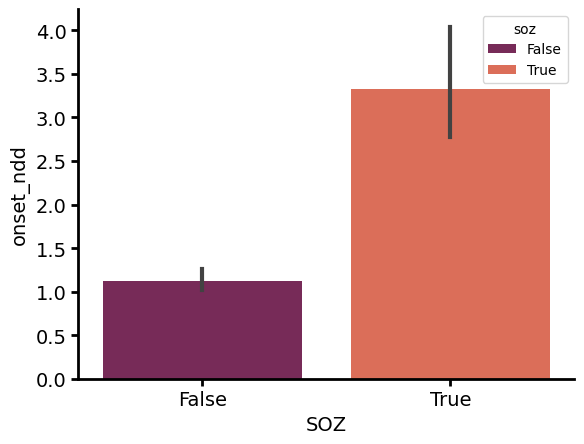

In [62]:
sns.barplot(data=plt_ndd_vals,x='soz',y='onset_ndd',hue='soz',palette='rocket')
sns.despine()
plt.xlabel('SOZ')
mask1 = (plt_ndd_vals['soz'])
n1 = len(plt_ndd_vals[mask1])
n2 = len(plt_ndd_vals[~mask1])

u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].onset_ndd,plt_ndd_vals[~mask1].onset_ndd)
print(u,p)
print(u/(n1*n2))
print(plt_ndd_vals[mask1].onset_ndd.mean())
print(plt_ndd_vals[~mask1].onset_ndd.mean())

5.2932315
1.3178664
0.9105691056910569


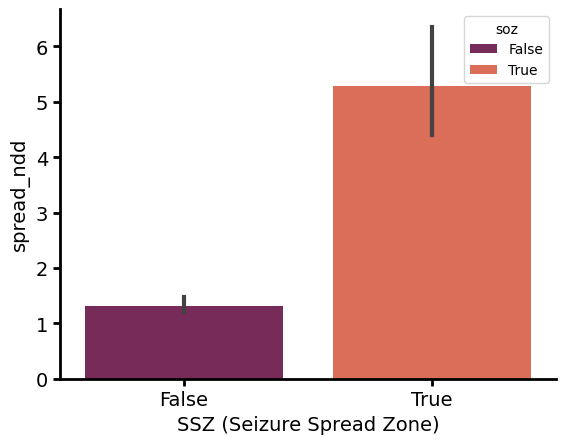

In [59]:
sns.barplot(data=plt_ndd_vals,x='soz',y='spread_ndd',hue='soz',palette='rocket')
sns.despine()
plt.xlabel('SSZ (Seizure Spread Zone)')
u,p = sc.stats.mannwhitneyu(plt_ndd_vals[mask1].spread_ndd,plt_ndd_vals[~mask1].spread_ndd);
print(plt_ndd_vals[mask1].spread_ndd.mean())
print(plt_ndd_vals[~mask1].spread_ndd.mean())
print(u/(n1*n2))

## Region Agreement